# Atelier #1 - Transfert de style neuronal avec TensorFlow

Chaque noteobook commence par ces trois lignes; ils garantissent que toutes les modifications apportées aux modules et paquets que vous développez "en dehors" du Jupyter Notebook sont automatiquement rechargées lorsque modifiés. Tous les graphiques et images sont affichées.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Chargement des librairies

In [2]:
# Suppression des warnings de manière générale
import warnings
warnings.filterwarnings('ignore')

In [3]:
import time
import IPython.display
from pathlib import Path

from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

from utils import load_img, show_img, load_and_process_img, show_results, deprocess_img, compute_grads, get_feature_representations, gram_matrix

2023-09-25 14:11:25.584153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 14:11:26.188623: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Quelques paramètres d'affichage...
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

---
## Vérification de la version de TensorFlow

La version de TensorFlow (GPU) utilisée pour cet exercice doit être la `2.10.0`. L'installation peut-être effectué à l'aide de l'utilitaire `pip`:

`pip install tensorflow`

In [5]:
tf.__version__

'2.13.0'

---
## Vérification de la version de cuDNN

In [18]:
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

---
## Chemins vers les images de contenu et de style

Placez vos images dans le répertoire `images`

In [10]:
CONTENT = Path('images/will.jpg')
STYLE = Path('images/joconde.jpg')

Les images sélectionnées pour le transfert de style neuronal sont:

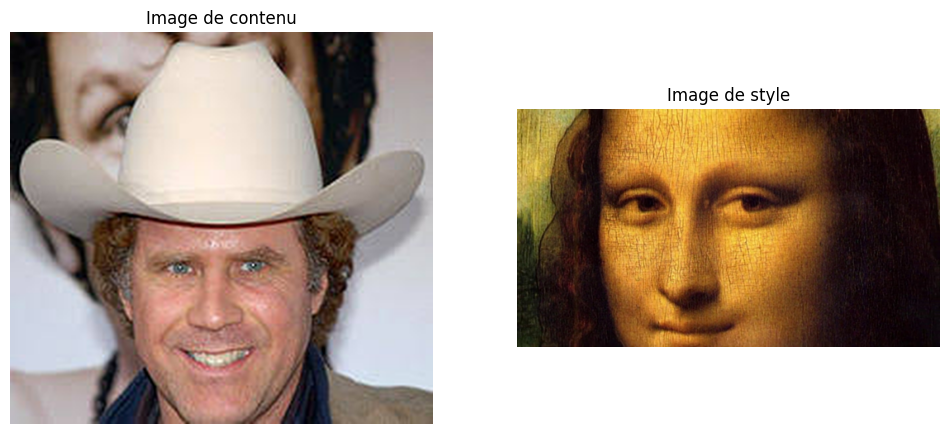

In [11]:
content = load_img(CONTENT).astype('uint8')
style = load_img(STYLE)
plt.subplot(1, 2, 1)
show_img(content, 'Image de contenu')
plt.axis('off')
plt.subplot(1, 2, 2)
show_img(style, 'Image de style')
_ = plt.axis('off')

---
## Définition du modèle

In [12]:
# La couche de contenu (feature maps)
content_layers = ['block5_conv2'] 

# Les couches de style
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

En vous basant sur la documentation de [Keras](https://keras.io/applications/), compléter la fonction ci-dessous en utlisant un modèle pré-entraîné de type VGG19. La fonction à utiliser est la suivante:

`keras.applications.vgg19.VGG19(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)`
* Les deux couches pleinement connectées (FC, fully-connected) et la couche de sortie Softmax ne devront pas être inclues
* Les poids à utiliser doivent correspondre à VGG19 pré-entraîné sur ImageNet

![Architecture de VGG19](static/VGG19.jpg)

In [13]:
def get_model():
    
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    # Couches de sortie correspondant aux couches de style et de contenu
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    # Construction du modèle 
    return models.Model(vgg.input, model_outputs)

---
## Transfert de style neuronal

In [14]:
# Paramètres
lr = 5
epsilon = 1e-1
num_iterations = 1000
content_weight = 1e3
style_weight = 1e-2

In [15]:
def run_style_transfer(content_path, style_path,
                       num_iterations=num_iterations, content_weight=content_weight, style_weight=style_weight): 
    
    # Le transfert de style n'implique pas d'entraînement à proprement parler
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
  
    # Pour obtenir les représentations de contenu (feature) et de style à partir des couches cachées sélectionnées 
    style_features, content_features = get_feature_representations(model, content_path, style_path, num_style_layers)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
    # Image initiale
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    
    # Creation de l'optimiseur
    opt = tf.optimizers.Adam(learning_rate=lr, epsilon=epsilon)

    # Sauvegarde du meilleur résultat
    best_loss, best_img = float('inf'), None
  
    # Configuration 
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features,
      'num_style_layers': num_style_layers,
      'num_content_layers': num_content_layers
    }
    
    # Transfer de style avec affichage
    iter_count = 1
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
  
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
    
        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval== 0:
             start_time = time.time()
      
        plot_img = init_image.numpy()
        plot_img = deprocess_img(plot_img)
        imgs.append(plot_img)
        IPython.display.clear_output(wait=True)
        IPython.display.display_png(Image.fromarray(plot_img))
        print('Iteration: {}'.format(i))        
        print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    
      
    return best_img, best_loss 

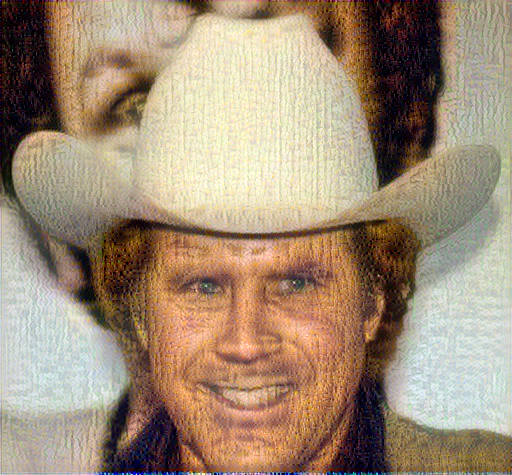

Iteration: 99
Total loss: 1.0130e+06, style loss: 5.1067e+05, content loss: 5.0236e+05, time: 23.0743s
Total time: 257.7838s


In [19]:
best_img, best_loss = run_style_transfer(CONTENT, STYLE, num_iterations=100)

---
## Résultats

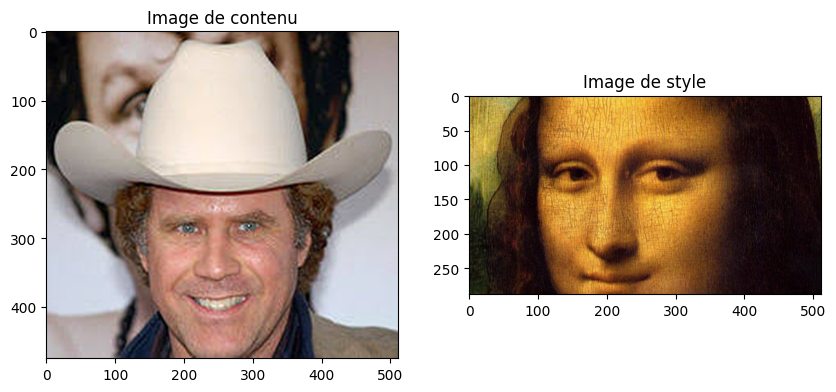

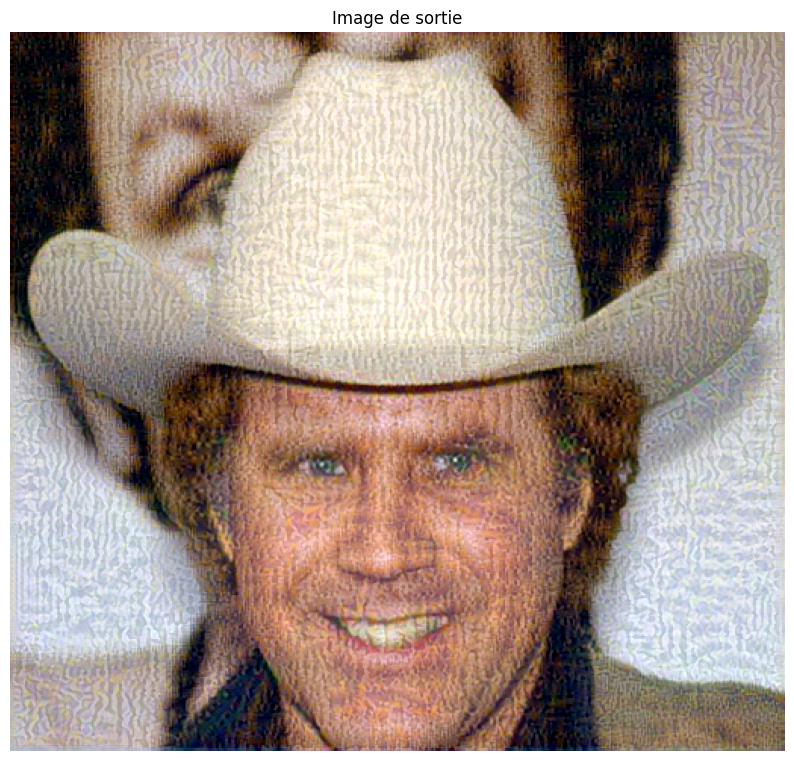

In [36]:
show_results(best_img, CONTENT, STYLE)

---
## Références

* [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)
* [Neural Style Transfer: Creating Art with Deep Learning using tf.keras and eager execution](https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398)
* [Transfer Learning in Tensorflow (VGG19 on CIFAR-10): Part 1](https://towardsdatascience.com/transfer-learning-in-tensorflow-9e4f7eae3bb4)